In [ ]:
!pip install keras
!pip install tensorflow

In [ ]:
#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Google_Drive_logo.png/600px-Google_Drive_logo.png' height="50" alt="Gdrive-logo"/></center>
#@markdown <center><h3>Mount GDrive to /content/drive</h3></center><br>
MODE = "MOUNT" #@param ["MOUNT", "UNMOUNT"]
#Mount your Gdrive! 
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")

Mounted at /content/drive


In [209]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from os import listdir
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers import Adam

from torchvision import datasets, models, transforms
from PIL import Image
from skimage import transform
import random
from google.colab import files
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [ ]:
#@title CPU, Memory check
!lscpu | grep "CPU(s):"
!lscpu | grep Hz

!cat /proc/meminfo | grep MemTotal

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

CPU(s):              2
NUMA node0 CPU(s):   0,1
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
CPU MHz:             2000.180
MemTotal:       13302920 kB
Found GPU at: /device:GPU:0


In [174]:
dataset_train = '/content/drive/MyDrive/Style_Transfer_CCVAE/data/train/'
dataset_val = '/content/drive/MyDrive/Style_Transfer_CCVAE/data/val/'

In [ ]:
# Import TensorFlow/Keras ResNet50 model
base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
#base_model.summary()

In [ ]:
# Add last layer with three categories
last_layer = base_model.get_layer('conv5_block3_out')
print(last_layer.output_shape)
x = Flatten()(last_layer.output)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation = 'softmax')(x)
model = Model(base_model.input, x)
#model.summary()

(None, 7, 7, 2048)


In [ ]:
# Define optimizer, compile model
optimizer = Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Preprocess and load training and validation data
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

training_set = train_datagen.flow_from_directory(dataset_train,
                                                 target_size = (224, 224),
                                                 color_mode='rgb',
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

validation_set = validation_datagen.flow_from_directory(dataset_val,
                                                        target_size = (224, 224),
                                                        color_mode='rgb',
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle=True)

Found 2929 images belonging to 3 classes.
Found 990 images belonging to 3 classes.


In [ ]:
history = model.fit(training_set,
                    steps_per_epoch= 2929 // 16,
                    epochs = 20,
                    validation_data = validation_set,
                    validation_steps = 50)

Epoch 1/20
183/183 [==============================] - 106s 551ms/step - loss: 1.5211 - accuracy: 0.5479 - val_loss: 0.6676 - val_accuracy: 0.7525
Epoch 2/20
183/183 [==============================] - 99s 538ms/step - loss: 0.8025 - accuracy: 0.7470 - val_loss: 0.5202 - val_accuracy: 0.8238
Epoch 3/20
183/183 [==============================] - 100s 544ms/step - loss: 0.5686 - accuracy: 0.8170 - val_loss: 0.4282 - val_accuracy: 0.8388
Epoch 4/20
183/183 [==============================] - 99s 542ms/step - loss: 0.4602 - accuracy: 0.8459 - val_loss: 0.3941 - val_accuracy: 0.8525
Epoch 5/20
183/183 [==============================] - 100s 547ms/step - loss: 0.3493 - accuracy: 0.8792 - val_loss: 0.3534 - val_accuracy: 0.8763
Epoch 6/20
183/183 [==============================] - 99s 542ms/step - loss: 0.2731 - accuracy: 0.8936 - val_loss: 0.3651 - val_accuracy: 0.8788
Epoch 7/20
183/183 [==============================] - 100s 546ms/step - loss: 0.2333 - accuracy: 0.9217 - val_loss: 0.3396 - va

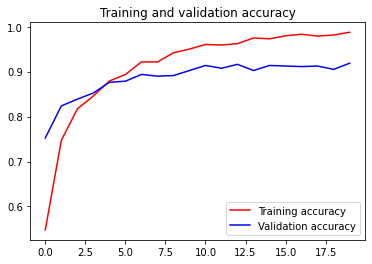

<Figure size 432x288 with 0 Axes>

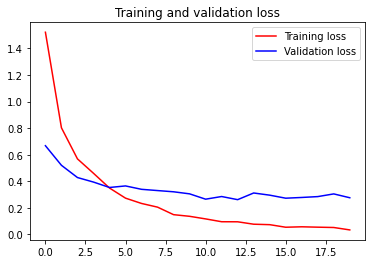

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [154]:
# Metrics
score = model.evaluate(validation_set)

print ("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print ("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

62/62 [==============================] - 29s 466ms/step - loss: 0.2782 - accuracy: 0.9152
loss: 27.82%
accuracy: 91.52%


In [155]:
# Export model
model.save("/content/drive/MyDrive/Style_Transfer_CCVAE/model/painter_classifier_model_ResNet-50.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


true class: 1 ( claude-monet )
Random image: claude-monet_cliffs-and-sailboats-at-pourville-1882.jpg
prediction: [[4.5168417e-04 9.9954730e-01 9.3038147e-07]]
predicted class: 1 ( claude-monet )


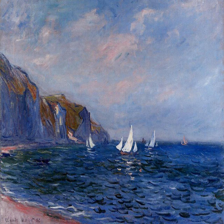

In [255]:
# Select random image from validation set and precict label (painter)
val_dirs = ['/content/drive/MyDrive/Style_Transfer_CCVAE/data/val/auguste-renoir/',
            '/content/drive/MyDrive/Style_Transfer_CCVAE/data/val/claude-monet/', 
            '/content/drive/MyDrive/Style_Transfer_CCVAE/data/val/vincent-van-gogh/']
class_names = ['auguste-renoir', 'claude-monet', 'vincent-van-gogh']
true_class = random.randint(0,2)
print("true class:", true_class, "(", class_names[true_class], ")")
random_dir = val_dirs[true_class]

# Get file list
val_images = listdir(random_dir)
im_name = val_images[random.randint(0,len(val_images)-1)]
im_path = random_dir + im_name
print("Random image:", im_name)

# load and preprocess the image
my_image = load_img(im_path, target_size=(224, 224))
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

# prediction
prediction = model.predict(my_image)
print("prediction:",prediction)
predicted_class = np.argmax(prediction)
print("predicted class:", predicted_class, "(", class_names[predicted_class], ")")

# display image
im = Image.open(im_path)
newsize = (224, 224)
im = im.resize(newsize)
im